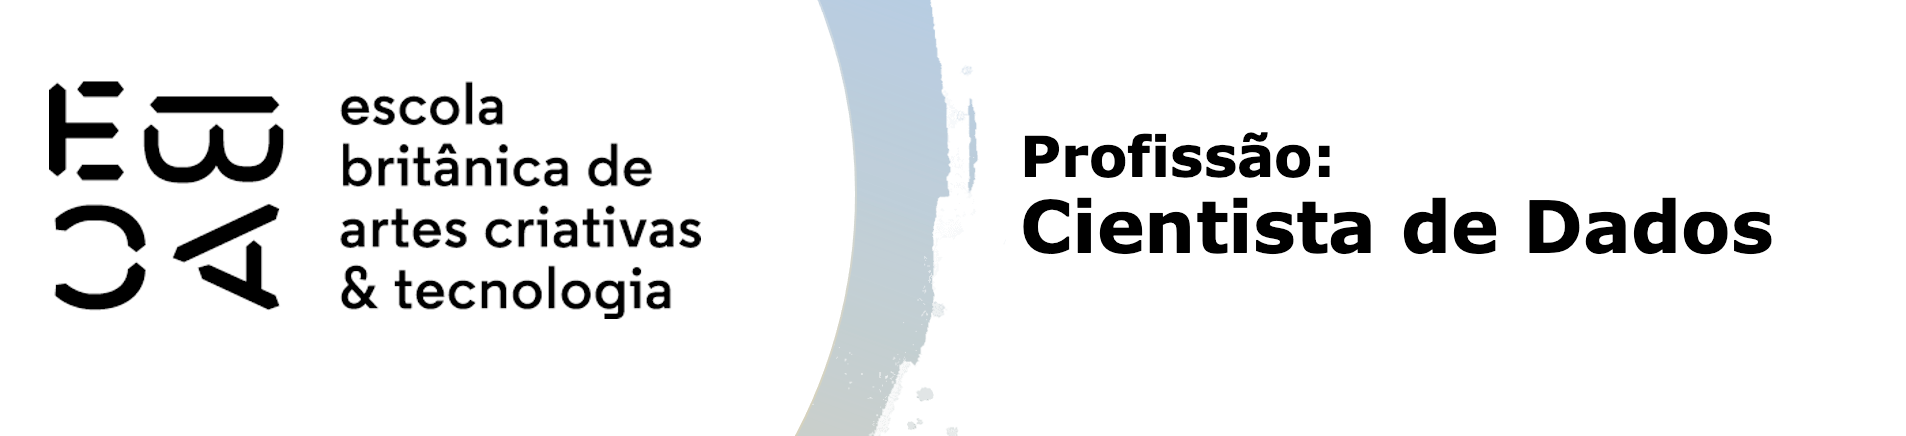

# Construindo um Credit Scoring para Cartão de Crédito

## Introdução
Neste projeto, estamos desenvolvendo um modelo de credit scoring, que é uma ferramenta utilizada por instituições financeiras para avaliar a capacidade de um potencial tomador de crédito em cumprir suas obrigações financeiras. O modelo será construído com base em um desenho amostral de 15 safras, utilizando 12 meses de performance.

## Carregamento dos Dados
Vamos carregar as bibliotecas necessárias, os dados e em seguida visualizar as primeiras linhas.


In [326]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

# Modelagem e métricas
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve, roc_curve, make_scorer,
)
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Pré-processamento
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Ferramentas adicionais
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
from sklearn.utils import resample
from pycaret.classification import *

In [239]:
# Carregando os dados
df = pd.read_feather('credit_scoring.ftr')

In [240]:
# Visualizando as primeiras linhas do dataframe
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


# Amostragem
Aqui, vamos separar as safras (representadas pela variável 'data_ref') para validação out of time (oot). 
Serão usados os três últimos meses de dados como conjunto de validação, enquanto os demais serão usados para treino. 

In [241]:
# Convertendo a coluna 'data_ref' para o formato datetime para manipulação de datas
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Identificando os três últimos meses únicos na coluna 'data_ref' para validação out of time
ultimos_tres_meses = df['data_ref'].unique()[-3:]

# Separando os dados de validação out of time (oot) - esses dados não serão usados no treinamento
df_oot = df[df['data_ref'].isin(ultimos_tres_meses)]

# Separando os dados de treino (todos os dados exceto os de validação oot)
df_treino = df[~df['data_ref'].isin(ultimos_tres_meses)]

# Removendo as colunas 'index' e 'data_ref' dos datasets de treino e validação, pois não serão usadas como variáveis explicativas
df_treino = df_treino.drop(columns=['index', 'data_ref'])
df_oot = df_oot.drop(columns=['index', 'data_ref'])

# Verificando o número de linhas nos conjuntos de treino e validação
print(f"Número de linhas no conjunto de treino: {df_treino.shape[0]}")
print(f"Número de linhas no conjunto de validação oot: {df_oot.shape[0]}")

Número de linhas no conjunto de treino: 600000
Número de linhas no conjunto de validação oot: 150000


# Descritiva Básica Univariada
Nesta seção, realizei uma análise descritiva básica univariada da base de dados. Inicialmente, descrevemos a base quanto ao número de linhas e ao número de linhas para cada mês em 'data_ref'. Em seguida, realizamos uma descrição univariada para cada variável, considerando suas naturezas distintas, sejam elas qualitativas ou quantitativas.

### Número total de linhas e linhas por mês em 'data_ref'

In [242]:
# Descrição básica da base
num_linhas_total = df.shape[0]
print(f"Número total de linhas: {num_linhas_total}")

# Número de linhas para cada mês em 'data_ref'
linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("\nNúmero de linhas por mês em 'data_ref':")
print(linhas_por_mes)

Número total de linhas: 750000

Número de linhas por mês em 'data_ref':
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


### Descrição Univariada das Variáveis Qualitativas

In [243]:
# Descrição univariada das variáveis qualitativas
print("\nDescrição univariada das variáveis qualitativas:")
variaveis_qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 
                          'tipo_renda', 'educacao', 'estado_civil', 
                          'tipo_residencia', 'mau']
for var in variaveis_qualitativas:
    print(f"\nDescrição de '{var}':")
    print(df[var].value_counts())


Descrição univariada das variáveis qualitativas:

Descrição de 'sexo':
F    504580
M    245420
Name: sexo, dtype: int64

Descrição de 'posse_de_veiculo':
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64

Descrição de 'posse_de_imovel':
S    503692
N    246308
Name: posse_de_imovel, dtype: int64

Descrição de 'tipo_renda':
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: tipo_renda, dtype: int64

Descrição de 'educacao':
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: educacao, dtype: int64

Descrição de 'estado_civil':
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: estado_civil, dtype: int64

Descrição de 'tipo_residencia':
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúd

### Descrição univariada das variáveis quantitativas

In [244]:
# Descrição univariada das variáveis quantitativas
print("\nDescrição univariada das variáveis quantitativas:")
variaveis_quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 
                           'qt_pessoas_residencia', 'renda']
df[variaveis_quantitativas].describe()


Descrição univariada das variáveis quantitativas:


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04
std,0.739379,11.229868,6.687455,0.903428,7.910601e+04
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


<div style="background-color: #FAE1BE">

## Resumo da Análise

### Número total de linhas
Há 750,000 linhas na base de dados, o que indica uma base de dados bastante grande.

### Número de linhas por mês em 'data_ref'
Cada mês tem exatamente 50,000 linhas, o que sugere uma divisão uniforme dos dados ao longo do tempo.

### Variáveis Qualitativas

- **Sexo**: Há mais mulheres (F) do que homens (M) na base de dados.
- **Posse de Veículo e Imóvel**: A maioria não possui veículo, mas possui imóvel.
- **Tipo de Renda**: A maioria é assalariada, seguida por empresários e pensionistas.
- **Educação**: A maioria tem educação de nível médio, seguida por superior completo.
- **Estado Civil**: A maioria é casada.
- **Tipo de Residência**: A maioria vive em casa própria.
- **Mau (Inadimplência)**: A grande maioria dos registros são de pessoas que não foram inadimplentes.

### Variáveis Quantitativas

- **Quantidade de Filhos**: Em média, os clientes têm menos de meio filho, mas alguns têm até 14.
- **Idade**: A idade varia de 22 a 68 anos, com uma média de aproximadamente 44 anos.
- **Tempo de Emprego**: Em média, os clientes têm quase 8 anos de emprego, mas alguns têm quase 43 anos.
- **Quantidade de Pessoas na Residência**: Em média, há pouco mais de 2 pessoas por residência.
- **Renda**: Há uma grande variação na renda, com a média sendo puxada para cima por valores extremamente altos (o que é indicado pelo desvio padrão muito alto). A mediana de cerca de 7,862 é provavelmente um indicador mais realista da renda típica.
</div>

# Análise Bivariada

Nesta seção, iremos realizar uma análise bivariada das variáveis. A análise bivariada é útil para entender a relação entre duas variáveis. Isso pode nos ajudar a entender melhor as dinâmicas e potenciais correlações presentes no conjunto de dados.

## Análise para Variáveis Qualitativas

Para as variáveis qualitativas, vamos utilizar gráficos de barras ou boxplots para visualizar a relação entre as variáveis e a inadimplência.

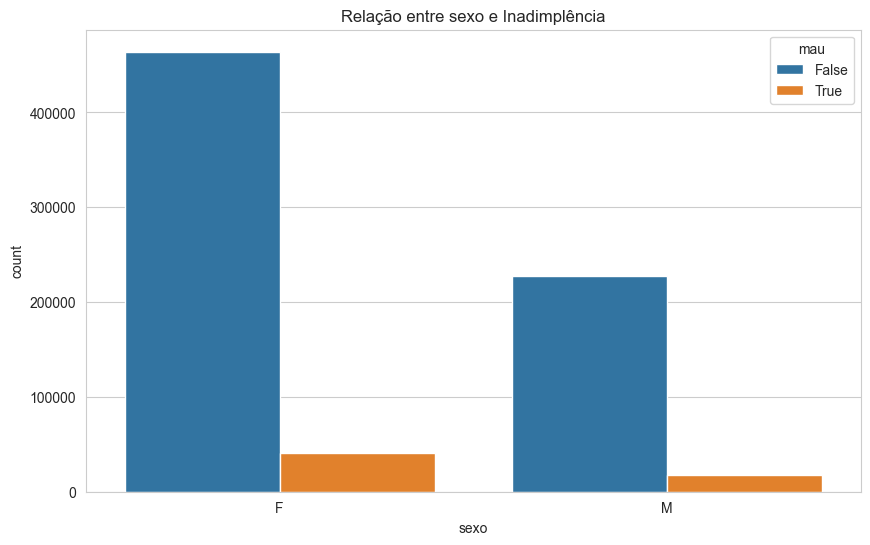

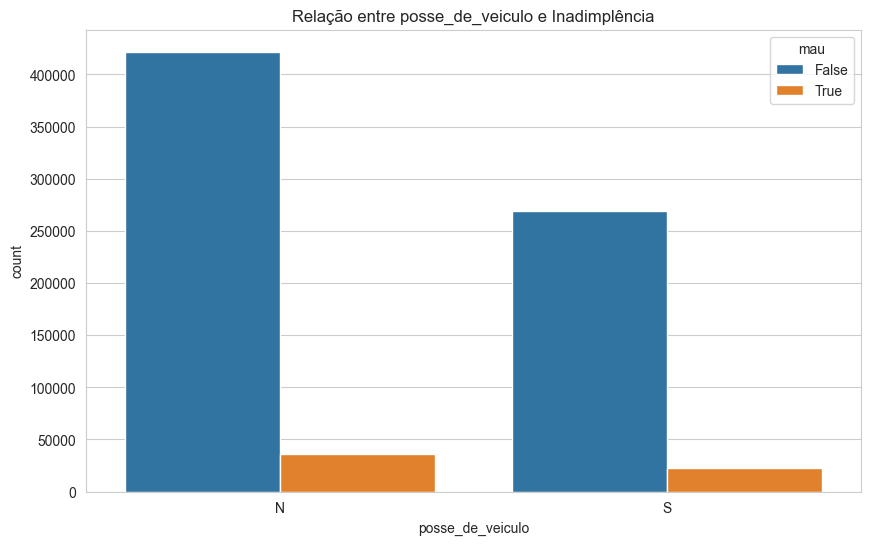

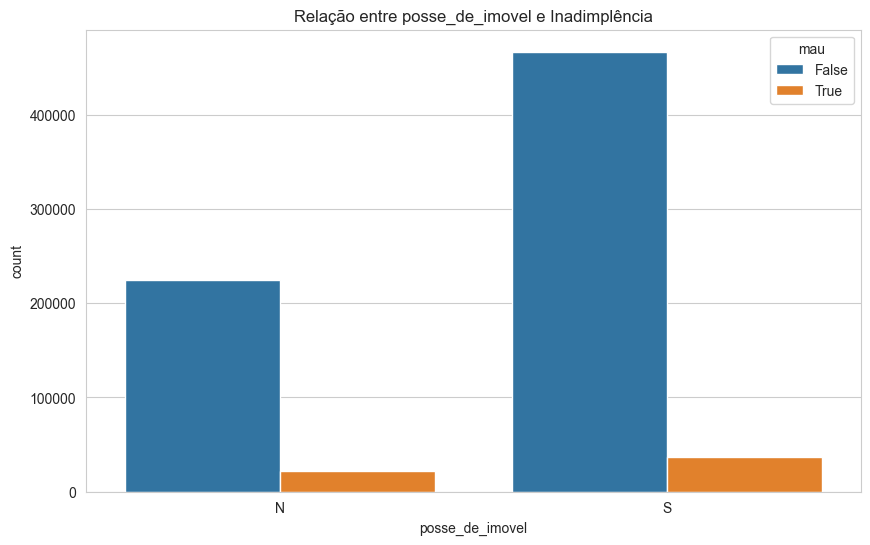

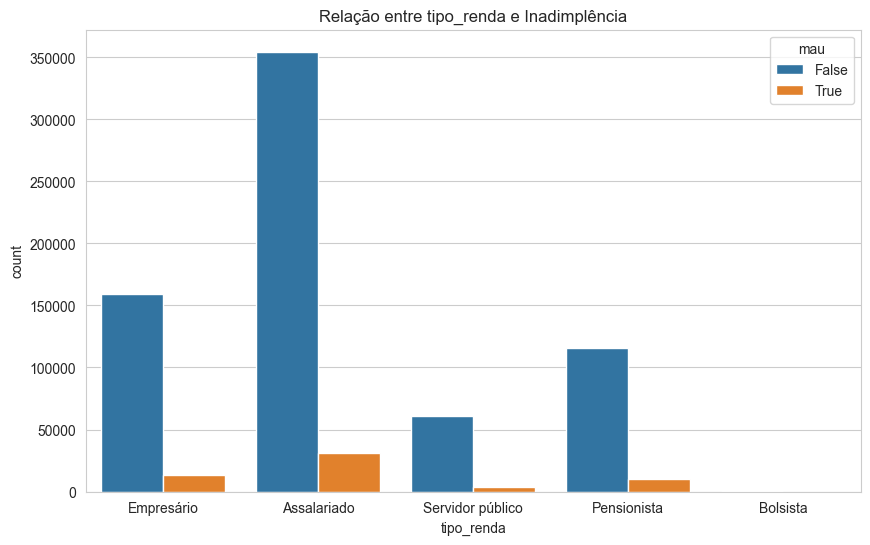

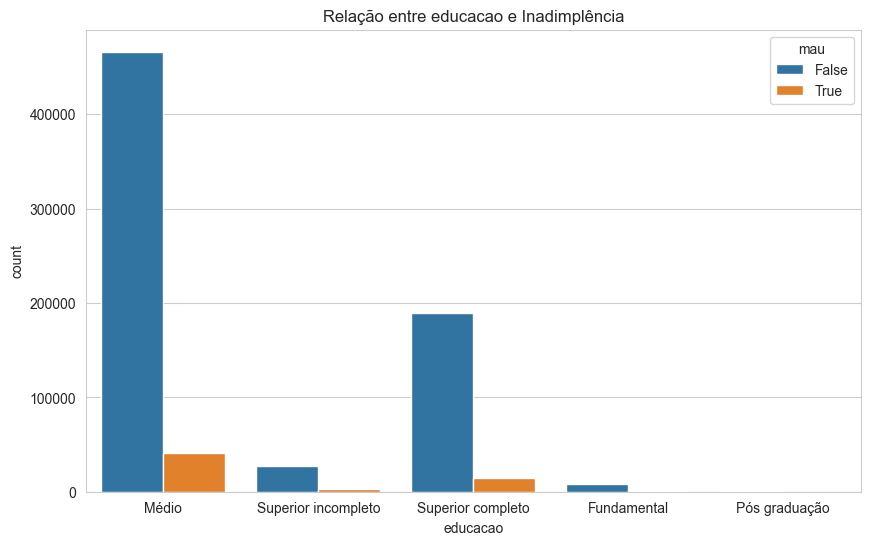

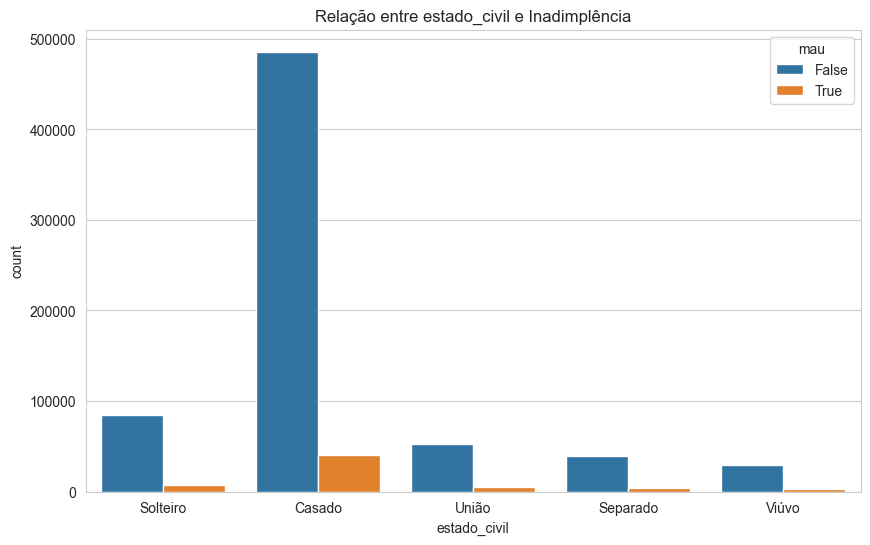

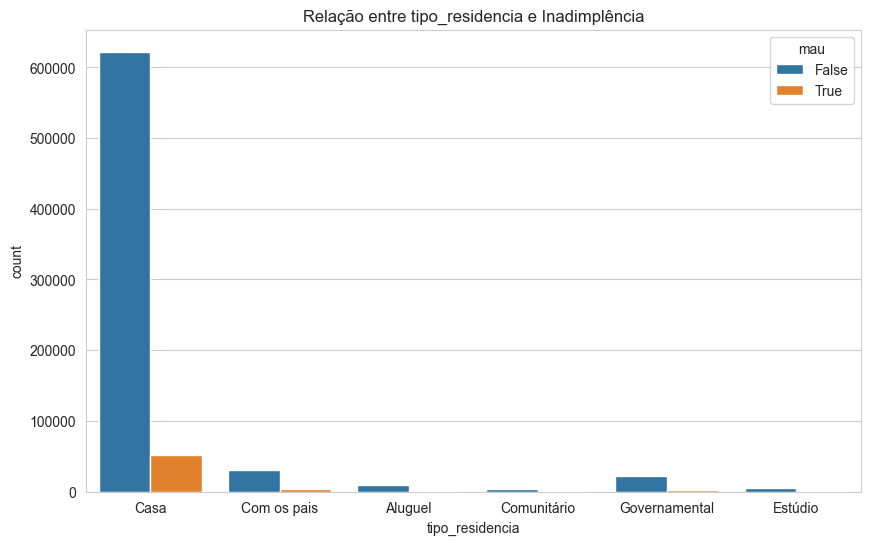

In [245]:
# Definindo o estilo dos gráficos
sns.set_style("whitegrid")

# Para variáveis qualitativas, podemos usar gráficos de barras ou boxplots para visualizar a relação
for column in ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='mau', data=df)
    plt.title(f'Relação entre {column} e Inadimplência')
    plt.show()

## Análise para Variáveis Quantitativas

Para as variáveis quantitativas, podemos utilizar histogramas ou gráficos de densidade para visualizar a distribuição e boxplots para entender as diferenças nas distribuições condicionadas à inadimplência.


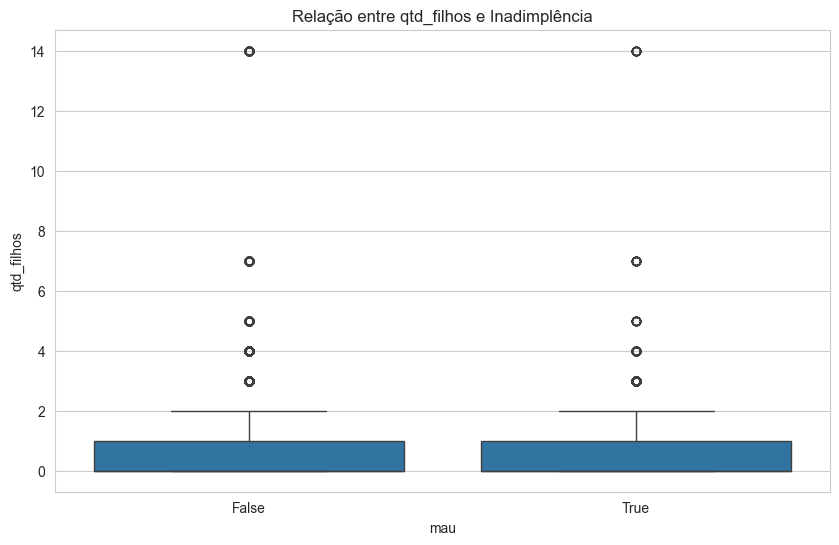

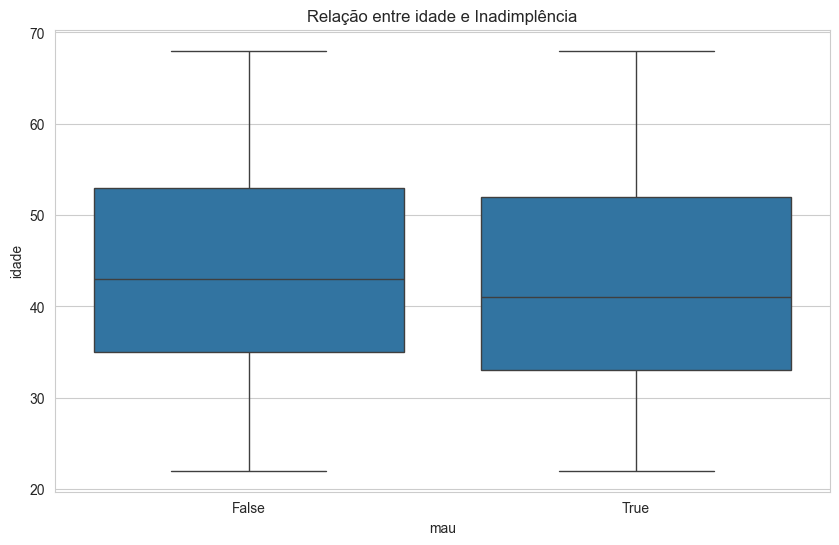

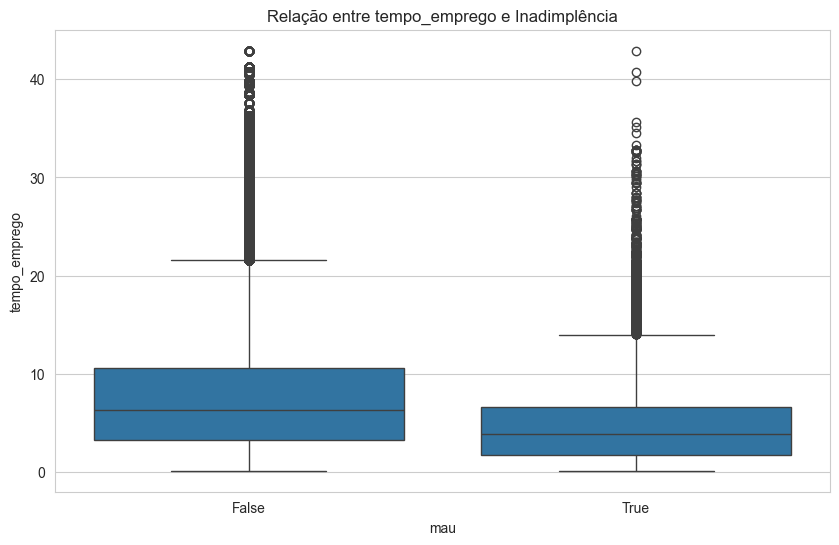

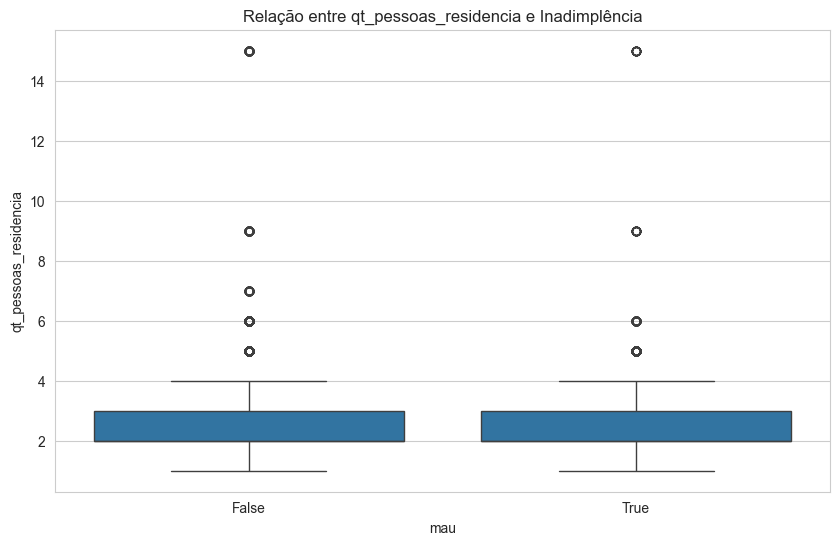

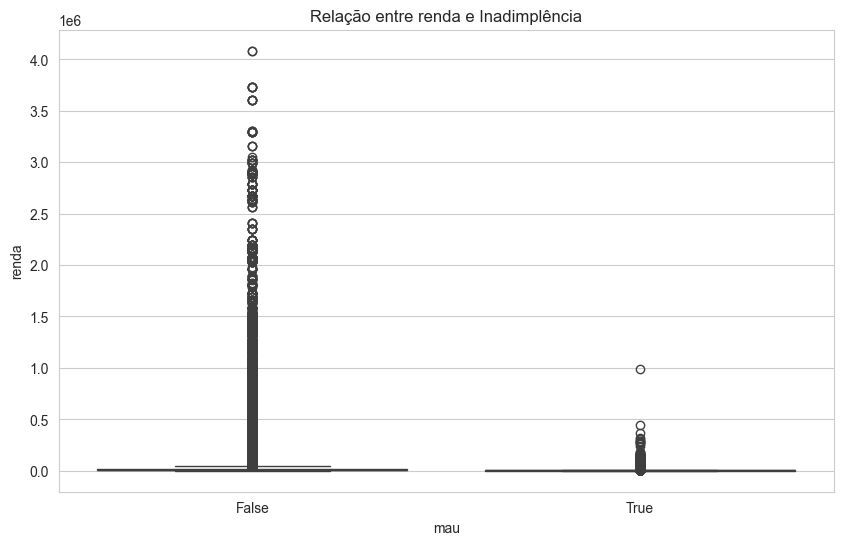

In [246]:
# Para variáveis quantitativas, podemos usar histogramas ou gráficos de densidade para visualizar a distribuição
# ou boxplots para entender as diferenças nas distribuições condicionadas à inadimplência
for column in ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='mau', y=column, data=df)
    plt.title(f'Relação entre {column} e Inadimplência')
    plt.show()

<div style="background-color: #FAE1BE">

## Resumo da Análise Descritiva Bivariada

### Relação entre sexo e Inadimplência:
- A quantidade de pessoas do sexo feminino (F) no dataset é significativamente maior do que a do sexo masculino (M).
- A inadimplência entre as pessoas do sexo feminino é relativamente baixa em comparação com o total. Para o sexo masculino, a inadimplência também é baixa, mas a diferença entre os inadimplentes e não inadimplentes parece ser menor do que no sexo feminino.

### Relação entre posse de veículo e Inadimplência:
- A maioria das pessoas não possui veículo (N).
- Entre aqueles que não possuem veículo, a taxa de inadimplência é baixa. Entre os que possuem veículo (S), a taxa de inadimplência também é baixa, mas parece ser um pouco maior proporcionalmente em comparação com os que não possuem.

### Relação entre posse de imóvel e Inadimplência:
- Há mais pessoas que possuem imóvel (S) do que aquelas que não possuem (N).
- A inadimplência entre aqueles que possuem imóvel é mais baixa em comparação com o total. Para aqueles que não possuem imóvel, a inadimplência é um pouco mais alta proporcionalmente.

### Conclusões:
- **Sexo:** O sexo feminino tem uma representação maior no dataset. A inadimplência, proporcionalmente, parece ser menor entre o sexo feminino do que entre o sexo masculino.
- **Posse de veículo:** A posse de veículo não parece ser um forte indicador de inadimplência, já que as taxas são baixas em ambos os grupos. No entanto, há uma ligeira tendência de maior inadimplência entre os que possuem veículo.
- **Posse de imóvel:** Ter um imóvel parece estar associado a uma menor taxa de inadimplência.

### Educação e Inadimplência:
- O primeiro gráfico mostra a relação entre os níveis de educação e inadimplência. Parece que indivíduos com 'Médio' (provavelmente significando ensino médio) têm a contagem mais alta. As barras azuis indicam indivíduos que não ficaram inadimplentes em seus pagamentos, enquanto as barras laranjas representam aqueles que ficaram. É notável que, à medida que o nível de educação aumenta (por exemplo, 'Pós-graduação'), o número de indivíduos diminui. A taxa de inadimplência parece ser maior para aqueles com 'Superior incompleto' (provavelmente algum ensino superior, mas sem diploma) em comparação com outros níveis de educação.

### Estado Civil e Inadimplência:
- O segundo gráfico mostra a relação entre o estado civil e a inadimplência. Indivíduos 'Casados' dominam o gráfico, com a maioria não ficando inadimplente em seus pagamentos. Vale a pena notar que os indivíduos 'Solteiros' têm uma taxa de inadimplência notável quando comparados ao seu total.

### Tipo de Residência e Inadimplência:
- O terceiro gráfico correlaciona os tipos de residências com inadimplência. A vasta maioria vive em 'Casas', com uma taxa de inadimplência mínima. Aqueles que moram 'Com os pais' mostram uma taxa de inadimplência significativa em relação ao seu total, enquanto outros tipos de residências, como 'Aluguel', têm uma presença menor no gráfico.

### Idade e Inadimplência:
- A idade mediana daqueles que não ficaram inadimplentes (Falso) parece ser ligeiramente superior à daqueles que ficaram (Verdadeiro).
- A faixa etária dos não inadimplentes parece ser mais ampla em comparação com os inadimplentes.

### Duração do Emprego e Inadimplência:
- A mediana da duração do emprego dos não inadimplentes é ligeiramente superior à dos inadimplentes.
- Há mais outliers na categoria de não inadimplentes, indicando alguns indivíduos com uma duração de emprego muito longa que não ficaram inadimplentes.

### Número de Pessoas na Residência e Inadimplência:
- O número mediano de pessoas na residência é quase o mesmo para ambas as categorias.
- Ambas as categorias têm alguns outliers, mas não parece haver uma tendência clara indicando uma relação forte entre o número de pessoas em uma residência e a inadimplência.
</div>

# Desenvolvimento do Modelo

Nesta etapa, vamos desenvolver um modelo de credit scoring utilizando regressão logística. O processo incluirá o tratamento de valores ausentes (missings), o tratamento de outliers e 'zeros estruturais'. Além disso, realizaremos agrupamentos de categorias quando apropriado, conforme discutido em aula. Ao final, proporemos uma equação preditiva para a variável 'mau' e discutiremos a significância das categorias.

## Tratamento de Valores Ausentes

Antes de desenvolver o modelo, é importante verificar e tratar os valores ausentes no dataset, pois eles podem afetar a performance do modelo.

In [247]:
# Verificando a presença de valores missing no dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

tempo_emprego    125957
dtype: int64


In [248]:
# Tratando valores ausentes na variável 'tempo_emprego'
# Substituindo valores ausentes pela mediana da variável
df['tempo_emprego'].fillna(df['tempo_emprego'].median(), inplace=True)

In [249]:
# Verificando novamente a presença de valores missing no dataset
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


## Tratamento de Outliers

Os outliers podem distorcer a análise e afetar a performance do modelo. Vamos identificar e tratar outliers nas variáveis quantitativas.

In [250]:
# Função para tratar outliers baseada no IQR
def tratar_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Tratando os outliers
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound

# Selecionando colunas numéricas para tratar outliers
num_columns = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Aplicando a função para tratar outliers em cada coluna numérica
for column in num_columns:
    tratar_outliers(df, column)

# Verificando e visualizando sumário estatístico após tratar os outliers
print(df[num_columns].describe())

          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  750000.000000          750000.000000   
mean        0.423100      43.804733       6.961731               2.202521   
std         0.692714      11.229868       4.676414               0.865866   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.635616               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000       9.090411               3.000000   
max         2.500000      68.000000      17.272603               4.500000   

               renda  
count  750000.000000  
mean    13035.214824  
std     12665.605731  
min       107.670000  
25%      3467.700000  
50%      7861.820000  
75%     18318.280000  
max     40594.150000  


## Verificação dos Tipos de Dados

Antes de qualquer tratamento ou transformação, é importante entender os tipos de dados presentes no nosso dataset. Isso nos ajudará a decidir como lidar com cada variável.

In [251]:
print(df.dtypes)

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                      float64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                           float64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object


## Conversão de Variáveis Categóricas em Dummy

As variáveis categóricas não podem ser utilizadas diretamente em modelos matemáticos. Vamos convertê-las em variáveis dummy para que possam ser incluídas no modelo de regressão logística.

In [252]:
# Convertendo variáveis categóricas em variáveis dummy
categorical_columns = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

## Verificação dos Novos Tipos de Dados

Após a conversão, vamos verificar os tipos de dados novamente para garantir que as variáveis categóricas foram convertidas corretamente.

In [253]:
print(df.dtypes)

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                              float64
idade                                   float64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                        bool
sexo_M                                    uint8
posse_de_veiculo_S                        uint8
posse_de_imovel_S                         uint8
tipo_renda_Bolsista                       uint8
tipo_renda_Empresário                     uint8
tipo_renda_Pensionista                    uint8
tipo_renda_Servidor público               uint8
educacao_Médio                            uint8
educacao_Pós graduação                    uint8
educacao_Superior completo                uint8
educacao_Superior incompleto              uint8
estado_civil_Separado                     uint8
estado_civil_Solteiro                   

## Tratamento de Zeros Estruturais

Os zeros estruturais são aqueles que têm um significado específico no contexto dos dados. Por exemplo, uma renda de zero pode indicar desemprego. Vamos tratar esses valores, caso existam.

In [254]:
# Identificando zeros em colunas importantes
for col in ['tempo_emprego', 'renda']:
    print(f"{col} tem {df[col].isnull().sum()} valores nulos")
    print(f"{col} tem {len(df[df[col] == 0])} valores iguais a zero\n")

tempo_emprego tem 0 valores nulos
tempo_emprego tem 0 valores iguais a zero

renda tem 0 valores nulos
renda tem 0 valores iguais a zero



## Agrupamento de Categorias

Agrupamentos de categorias podem ajudar a simplificar o modelo e tornar as interpretações mais claras.

In [255]:
# Agrupando as categorias de educação
df['educacao_agrupada'] = df.apply(lambda row: 'Ensino Superior' if row['educacao_Superior completo'] == 1 or row['educacao_Superior incompleto'] == 1 else ('Pós-graduação' if row['educacao_Pós graduação'] == 1 else 'Ensino Médio'), axis=1)

# Agrupando as categorias de estado civil
df['estado_civil_agrupado'] = df.apply(lambda row: 'Casado/União' if row['estado_civil_União'] == 1 else ('Outros' if row['estado_civil_Separado'] == 1 or row['estado_civil_Viúvo'] == 1 else 'Solteiro'), axis=1)

# Agrupando as categorias de tipo de residência
df['tipo_residencia_agrupada'] = df.apply(lambda row: 'Alugada' if row['tipo_residencia_Com os pais'] == 1 or row['tipo_residencia_Comunitário'] == 1 or row['tipo_residencia_Estúdio'] == 1 or row['tipo_residencia_Governamental'] == 1 else ('Outros' if row['tipo_residencia_Casa'] == 0 else 'Própria'), axis=1)

## Preparação dos Dados para o Modelo Preditivo

Antes de desenvolver o modelo preditivo, precisamos preparar nossos dados. Isso envolve a criação de variáveis dummy para as categorias restantes, separação das variáveis independentes (features) e da variável dependente (target), além de dividir o conjunto de dados em treino e teste.

In [256]:
# Criando variáveis dummy para as categorias restantes
df = pd.get_dummies(df, columns=['educacao_agrupada', 'estado_civil_agrupado', 'tipo_residencia_agrupada'])

# Separando as variáveis independentes e dependente
X = df.drop(['mau', 'data_ref'], axis=1)  # Remover as colunas 'mau' e 'data_ref'
y = df['mau']  # Variável alvo

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalização dos Dados

A normalização dos dados é uma etapa importante, especialmente para modelos lineares como a regressão logística. Isso garante que todas as variáveis contribuam igualmente para o resultado do modelo.

In [257]:
# Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Treinamento do Modelo de Regressão Logística

Com os dados preparados e normalizados, vamos treinar nosso modelo de regressão logística. Também definiremos pesos para as classes para lidar com desequilíbrios no conjunto de dados.

In [258]:
# Inicializando e treinando o modelo de Regressão Logística com pesos de classe
class_weights = {0: 1, 1: 10}
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 1, 1: 10})

## Avaliação do Modelo

Após treinar o modelo, é crucial avaliá-lo usando o conjunto de teste. Isso nos dará uma ideia de como o modelo se comporta com dados que não viu antes.


In [259]:
# Fazendo previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Exibindo os resultados da avaliação
print(f"Acurácia do Modelo: {accuracy}")
print(f"Matriz de Confusão: \n{conf_matrix}")
print(f"Relatório de Classificação: \n{class_report}")

Acurácia do Modelo: 0.62496
Matriz de Confusão: 
[[84443 53861]
 [ 2395  9301]]
Relatório de Classificação: 
              precision    recall  f1-score   support

       False       0.97      0.61      0.75    138304
        True       0.15      0.80      0.25     11696

    accuracy                           0.62    150000
   macro avg       0.56      0.70      0.50    150000
weighted avg       0.91      0.62      0.71    150000



## Desenvolvimento de um Modelo Avançado: XGBoost

Agora, vamos explorar um modelo de machine learning mais avançado conhecido como XGBoost. Este modelo é conhecido por sua eficácia em competições de dados e projetos do mundo real, especialmente em conjuntos de dados desbalanceados.

In [260]:
# Criando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo XGBoost com os dados de treino
xgb_model.fit(X_train_scaled, y_train)

# Fazendo previsões no conjunto de teste
xgb_predictions = xgb_model.predict(X_test_scaled)

# Avaliando o modelo
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)
xgb_classification_report = classification_report(y_test, xgb_predictions)

# Exibindo os resultados da avaliação
print(f"Acurácia do Modelo XGBoost: {xgb_accuracy}")
print(f"Matriz de Confusão: \n{xgb_confusion_matrix}")
print(f"Relatório de Classificação: \n{xgb_classification_report}")

Acurácia do Modelo XGBoost: 0.9222266666666666
Matriz de Confusão: 
[[137986    318]
 [ 11348    348]]
Relatório de Classificação: 
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138304
        True       0.52      0.03      0.06     11696

    accuracy                           0.92    150000
   macro avg       0.72      0.51      0.51    150000
weighted avg       0.89      0.92      0.89    150000



## Análise de Importância de Atributos

Uma parte crucial da modelagem preditiva é entender quais variáveis são mais importantes para o modelo. Isso pode nos dar insights sobre os fatores que mais influenciam na previsão de 'mau'. Vamos usar o modelo XGBoost para analisar a importância dos atributos.

### Importância dos Atributos com XGBoost

XGBoost fornece uma forma fácil de visualizar a importância de cada atributo no modelo. Isso é feito através da propriedade `feature_importances_` que retorna uma pontuação para cada atributo.

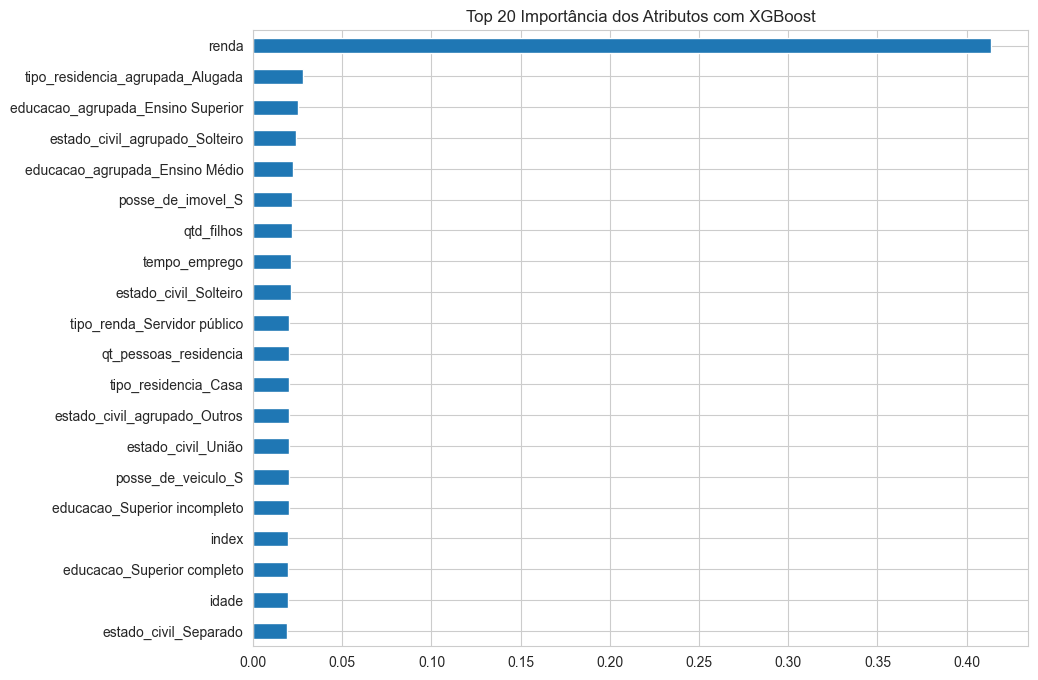

In [261]:
# Inicializando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo com os dados completos
xgb_model.fit(X, y)

# Obtendo a importância dos atributos e armazenando em um DataFrame
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Visualizando a importância dos atributos com um gráfico de barras horizontal e limitando aos top 20
top_n = 20
(feature_importances_xgb
    .sort_values(ascending=True) # Isso garante que os mais importantes ficam no topo
    .tail(top_n) # Seleciona os top N mais importantes
    .plot(kind='barh', figsize=(10,8), title='Top 20 Importância dos Atributos com XGBoost')) # gráfico de barras horizontal com tamanho aumentado
plt.show() # Mostra o gráfico

In [262]:
# Desativar avisos de futuras mudanças
warnings.simplefilter(action='ignore', category=FutureWarning)

# Análise de Correlação
# Inicialmente, vamos calcular a matriz de correlação para o dataframe.
correlation_matrix = df.corr()

# Mostramos as correlações da variável alvo 'mau' em ordem decrescente.
target_correlation = correlation_matrix['mau'].sort_values(ascending=False)
print(target_correlation)

mau                                   1.000000
tipo_residencia_Com os pais           0.013215
educacao_agrupada_Ensino Médio        0.013022
educacao_Médio                        0.011673
tipo_residencia_agrupada_Alugada      0.010454
index                                 0.009360
tipo_renda_Pensionista                0.007529
qtd_filhos                            0.006572
estado_civil_agrupado_Casado/União    0.006124
estado_civil_União                    0.006124
tipo_residencia_agrupada_Outros       0.005271
estado_civil_Solteiro                 0.004217
educacao_Superior incompleto          0.003621
qt_pessoas_residencia                 0.003405
estado_civil_Separado                 0.003270
tipo_residencia_Governamental         0.002689
tipo_residencia_Comunitário           0.001560
estado_civil_agrupado_Outros          0.000657
educacao_Pós graduação               -0.000678
educacao_agrupada_Pós-graduação      -0.000678
estado_civil_Viúvo                   -0.002789
posse_de_veic

# Otimização de Características com RFECV e Regressão Logística
## Padronização e Seleção de Recursos

In [263]:
## Padronização dos Dados
# Iniciando o objeto StandardScaler para padronizar os dados para ter média 0 e variância 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Aplica a padronização aos dados.

## Criando modelo de regressão Logística e criando uma instância do modelo LogisticRegression.
logistic_model = LogisticRegression()

## Selecionando características com RFECV
# Iniciando o RFECV com o modelo de regressão logística para seleção de recursos.
rfecv = RFECV(
    estimator=logistic_model, 
    step=1, 
    cv=StratifiedKFold(5), 
    scoring='accuracy'
)

# Treinando o RFECV com os dados padronizados e a variável alvo 'y'.
rfecv.fit(X_scaled, y)

## Resultados do RFECV
# Imprimindo o número ótimo de recursos e as características selecionadas pelo RFECV.
print("Número ótimo de características: %d" % rfecv.n_features_)
print('Características selecionadas: %s' % list(X.columns[rfecv.support_]))

Número ótimo de características: 1
Características selecionadas: ['renda']


# Análise Estatística de Variáveis Categóricas
## Teste de Qui-Quadrado para Associação de Atributos
O teste de qui-quadrado é utilizado para determinar se existe uma associação significativa entre duas variáveis categóricas. Neste exemplo, avaliamos a associação entre a variável alvo 'mau' e a variável categórica 'sexo_M'.

In [264]:
# Construindo a tabela de contingência entre 'mau' e 'sexo_M'
contingency_table = pd.crosstab(df['mau'], df['sexo_M'])  # Substitua 'sexo_M' pela sua variável categórica.

# Realização do teste de qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Exibição do p-valor para determinar a associação
print(f"P-value: {p}")

P-value: 4.2547733301804896e-27


# Avaliação de Modelo com Validação Cruzada
## Acurácia Média com RandomForest e Validação Cruzada
Utilizamos a validação cruzada para avaliar a robustez do modelo de classificação RandomForest. A acurácia média nos fornece uma estimativa da performance do modelo em diferentes divisões do conjunto de dados.

In [265]:
# Avaliando o modelo RandomForestClassifier com validação cruzada
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5)

# Exibindo a acurácia média
print("Acurácia média com validação cruzada: %0.2f" % scores.mean())

Acurácia média com validação cruzada: 0.87


In [266]:
# Exemplo para uma variável categórica 'categoria'
contingency_table = pd.crosstab(df['mau'], df['sexo_M'])  # Substitua 'categoria' pela variável categórica
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 4.2547733301804896e-27


# Avaliação do Modelo
Após treinar o modelo, é crucial avaliarmos seu desempenho para entender como ele poderá se comportar em dados não vistos anteriormente e qual é o seu poder discriminante. As métricas comuns para esta avaliação incluem a acurácia, que mede a porcentagem de previsões corretas, além do KS (Kolmogorov-Smirnov) e Gini, que ajudam a entender a capacidade do modelo de distinguir entre as classes.

In [267]:
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5)
print("Acurácia média com validação cruzada: %0.2f" % scores.mean())

Acurácia média com validação cruzada: 0.87


## Avaliação de Acurácia
A acurácia é uma medida inicial para entender a eficácia do modelo, indicando o percentual de classificações corretas realizadas sobre o conjunto de teste.

In [268]:
# Treinando o modelo com o conjunto de treinamento (X_train, y_train)
model.fit(X_train, y_train)

# Realizando previsões com o conjunto de teste (X_test)
y_pred = model.predict(X_test)

# Calculando e imprimindo a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

Acurácia: 0.6403933333333334


## Avaliação com KS e Gini
O KS e o Gini são métricas mais avançadas que avaliam a capacidade do modelo de diferenciar entre as categorias de resposta. Estes são calculados com base nas probabilidades de previsão e nos resultados reais.

In [269]:
# Calculando as probabilidades de previsão
y_prob = model.predict_proba(X_test)[:, 1]

# Calculando e imprimindo KS e Gini usando as probabilidades e as classes reais (y_test)
ks_statistic = ks_2samp(y_test, y_prob).statistic
gini_coefficient = 2 * roc_auc_score(y_test, y_prob) - 1

print(f"KS Statistic: {ks_statistic}")
print(f"Gini Coefficient: {gini_coefficient}")

KS Statistic: 0.9220266666666667
Gini Coefficient: 0.5286823115743047


# Implementação do Pipeline de Modelagem
## Utilização de Pipeline para Processamento e Classificação

O uso de um pipeline permite automatizar fluxos de trabalho de modelagem, integrando tanto a pré-processação dos dados quanto a aplicação de um modelo. Neste exemplo, estamos criando um pipeline que primeiro padroniza as variáveis independentes e, em seguida, aplica uma regressão logística para a classificação. O uso de pipeline facilita a implementação do modelo e garante que todos os passos sejam aplicados consistentemente durante o treinamento e as previsões.

In [270]:
# Definindo os passos do pipeline
# O primeiro elemento da tupla é um identificador do passo (string) e o segundo é um objeto transformador ou estimador
steps = [
    # Passo de padronização dos dados
    ('scaler', StandardScaler()),
    # Passo do modelo de regressão logística
    ('logistic_regression', LogisticRegression())
]

# Criando o pipeline
pipeline = Pipeline(steps)

# Ajustando o pipeline aos dados de treino
# X_train e y_train devem ser seus dados de treino
pipeline.fit(X_train, y_train)

# Fazendo previsões com o pipeline
# X_test é o seu conjunto de teste
y_pred = pipeline.predict(X_test)

# Avaliando o modelo
# y_test são as verdadeiras etiquetas do conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

Acurácia: 0.9220266666666667


## Pré processamento

# Pré-Processamento de Dados
## Identificação e Tratamento de Valores Ausentes

Nesta etapa do pré-processamento, o foco está na identificação e no tratamento de valores ausentes (nulos ou `NaNs`). O tratamento adequado de valores ausentes é crucial para garantir a qualidade do modelo preditivo. A estratégia de substituição dependerá da natureza dos dados:
- Para dados numéricos, pode-se considerar a substituição pela média, mediana ou até um valor específico baseado em conhecimento de domínio.
- Para dados categóricos, a moda ou uma categoria específica como 'Desconhecido' pode ser uma boa escolha.

Vamos primeiro identificar as colunas que contêm valores ausentes e, em seguida, decidir sobre a estratégia de imputação mais adequada.

In [271]:
# Identificar a quantidade de valores nulos em cada coluna
nulos = df.isnull().sum()

# Calcular a proporção de valores nulos em cada coluna
proporcao_nulos = df.isnull().mean()

# Exibir as colunas com valores nulos e suas respectivas quantidades e proporções
# Isso nos ajudará a entender a extensão dos dados ausentes em nosso dataframe
colunas_com_nulos = nulos[nulos > 0]
proporcoes_com_nulos = proporcao_nulos[proporcao_nulos > 0]
print("Colunas com valores nulos, quantidade e proporção:")
print(pd.concat([colunas_com_nulos, proporcoes_com_nulos], axis=1, keys=['Quantidade', 'Proporção']))

Colunas com valores nulos, quantidade e proporção:
Empty DataFrame
Columns: [Quantidade, Proporção]
Index: []


# Remoção de Outliers
## Identificação e Tratamento de Outliers na Variável 'Renda'

A presença de outliers pode ter um efeito significativo em nossos modelos preditivos, especialmente em algoritmos que são sensíveis a extremos, como regressões lineares. Por isso, é essencial identificar e tratar outliers apropriadamente. Existem várias técnicas para identificar outliers, como:
- Utilizar gráficos boxplot para visualização.
- Calcular o intervalo interquartílico (IQR) e definir limites para classificar valores extremos.
  
Após a identificação, podemos optar por remover os outliers ou substituí-los por um valor mais central, como a média ou mediana. A escolha dependerá da quantidade de outliers e do impacto que eles têm sobre os dados.

Quantidade de outliers: 0


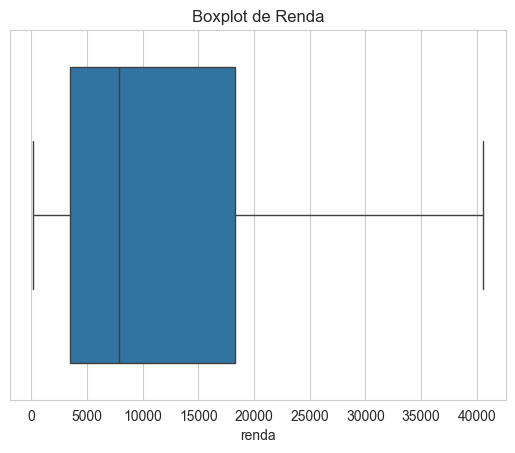

In [272]:
# Calculando o IQR para a coluna 'renda'
Q1 = df['renda'].quantile(0.25)
Q3 = df['renda'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites inferior e superior para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificando os outliers na coluna 'renda'
outliers = df[(df['renda'] < lower_bound) | (df['renda'] > upper_bound)]
print(f"Quantidade de outliers: {outliers.shape[0]}")

# Visualizando os outliers com um boxplot
sns.boxplot(x=df['renda'])
plt.title('Boxplot de Renda')
plt.show()

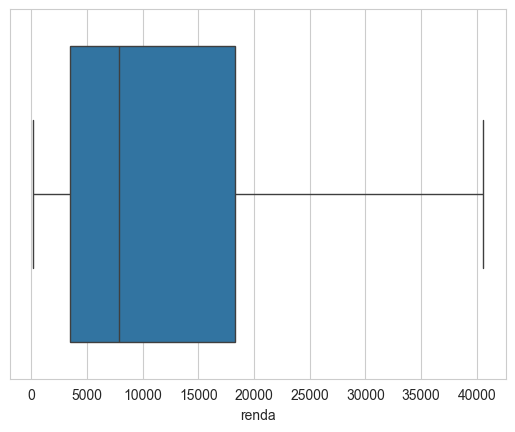

In [273]:
sns.boxplot(x=df['renda'])
plt.show()

# Seleção de Variáveis
## Análise da Importância das Características com Random Forest

A seleção de variáveis é uma etapa crítica na modelagem preditiva. Escolher as variáveis corretas pode melhorar a eficiência do modelo e evitar overfitting. Existem várias técnicas de seleção de variáveis, como métodos baseados em modelos, métodos estatísticos e métodos baseados em algoritmos como Boruta. Neste caso, usaremos a importância das características como fornecida por um modelo de Random Forest para determinar quais variáveis têm mais influência na previsão do target 'mau'.

In [274]:
print(df.columns)

Index(['data_ref', 'index', 'qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda', 'mau', 'sexo_M', 'posse_de_veiculo_S',
       'posse_de_imovel_S', 'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Médio', 'educacao_Pós graduação',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental',
       'educacao_agrupada_Ensino Médio', 'educacao_agrupada_Ensino Superior',
       'educacao_agrupada_Pós-graduação', 'estado_civil_agrupado_Casado/União',
       'estado_civil_agrupado_Outros', 'estado_civil_agrupado_Solteiro',
       'tipo_residencia_agrupada_Alugada', 'tipo_residencia_agrupada_Outros',
       'tipo_re

                               Feature  Importance
4                                renda    0.781301
2                        tempo_emprego    0.086922
1                                idade    0.071477
6                   posse_de_veiculo_S    0.007462
3                qt_pessoas_residencia    0.007407
5                               sexo_M    0.005771
0                           qtd_filhos    0.005745
9                tipo_renda_Empresário    0.005737
7                    posse_de_imovel_S    0.005528
11         tipo_renda_Servidor público    0.002757
17               estado_civil_Solteiro    0.002580
10              tipo_renda_Pensionista    0.001676
12                      educacao_Médio    0.001379
30      estado_civil_agrupado_Solteiro    0.001264
14          educacao_Superior completo    0.001151
28  estado_civil_agrupado_Casado/União    0.000957
18                  estado_civil_União    0.000922
16               estado_civil_Separado    0.000903
15        educacao_Superior inc

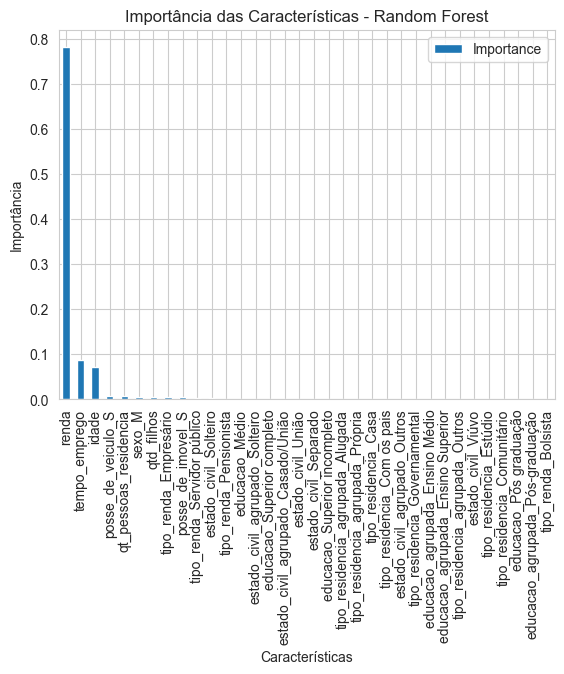

In [275]:
# Removendo a coluna 'index' e 'data_ref'
df = df.drop(columns=['index', 'data_ref'])

# Definindo as variáveis independentes (X) e a variável dependente (y)
X = df.drop('mau', axis=1)
y = df['mau']

# Inicializando e treinando o modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Calculando e exibindo a importância das variáveis
feature_importances = rf.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Ordenando as características por importância
importances_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importances_df)

# Visualizando a importância das características em um gráfico
importances_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Importância das Características - Random Forest')
plt.ylabel('Importância')
plt.xlabel('Características')
plt.show()

<div style="background-color: #FAE1BE">

## Notas sobre as descobertas
Importância das características:
- 'Renda' é a característica mais importante, indicando alta influência no modelo.
- 'tempo_emprego' também é importante, sugerindo que esse aspectos deve ser consideradosna análise.
- Características com importâncias muito baixas podem ser menos importantes para o modelo.")</div>

# Redução de Dimensionalidade com PCA

A redução de dimensionalidade é um passo crucial em muitos algoritmos de aprendizado de máquina para melhorar a eficiência e evitar a maldição da dimensionalidade. O PCA (Principal Component Analysis) é um método estatístico que permite simplificar a complexidade dos espaços dimensionais mantendo suas propriedades mais importantes.

## Remoção de Colunas Não Necessárias

Antes de aplicar o PCA, é importante preparar o conjunto de dados. Isso inclui a remoção de colunas que não serão usadas na análise, como identificadores únicos ou colunas de saída que estamos tentando prever.

## Normalização dos Dados

A normalização é um passo crítico antes de realizar o PCA porque o PCA é sensível à escala dos dados. A normalização garante que cada característica contribua igualmente para a análise.

## Aplicação do PCA

Após a normalização dos dados, o PCA é aplicado para reduzir a dimensionalidade do conjunto de dados para as cinco principais componentes. Isso resulta em um novo conjunto de dados com menos dimensões que ainda captura a essência dos dados originais.

## Resultados

Os resultados mostram as primeiras linhas do novo DataFrame após a aplicação do PCA e a variância explicada por cada componente principal. Isso dá uma ideia de quanto da informação original é capturada pelas componentes principais.


In [276]:
# Removendo as colunas que não serão utilizadas na análise
df_reduced = df.drop(columns=['mau'])

# Normalização dos dados para garantir que todas as características tenham igual importância
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_reduced)

# Aplicando do PCA para reduzir a dimensionalidade para 5 componentes principais
pca = PCA(n_components=5)
principal_components = pca.fit_transform(df_normalized)

# Convertendo os componentes principais em um DataFrame para análise
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Exibindo as primeiras linhas do DataFrame PCA
print("Primeiras linhas do DataFrame PCA:")
print(df_pca.head())

# Exibindo a variância explicada por cada componente principal
print("\nVariância explicada por cada componente principal:")
print(pca.explained_variance_ratio_)

Primeiras linhas do DataFrame PCA:
        PC1       PC2       PC3       PC4       PC5
0 -1.151026  0.379297 -0.437289 -1.174732  0.102128
1 -1.003387  0.132877 -1.220002 -0.183301  0.060017
2 -0.153846  0.375647 -2.417280  1.202248 -0.068204
3 -1.539035  0.348603 -0.577669 -0.647520 -0.196215
4  2.083051 -1.699372  0.551216 -1.186051 -0.010827

Variância explicada por cada componente principal:
[0.12671958 0.11337063 0.09074639 0.07510338 0.05902379]


<div style="background-color: #FAE1BE">

## Resultados

Os resultados abaixo representam as primeiras linhas do novo DataFrame após a aplicação do PCA e mostram os valores para os primeiros cinco componentes principais para as cinco primeiras observações do dataset:<br><br>
Em termos percentuais, temos:

PC1 explica 14.16% da variância.<br>
PC2 explica 13.07% da variância.<br>
PC3 explica 10.35% da variância.<br>
PC4 explica 7.72% da variância.<br>
PC5 explica 5.44% da variância.<br><br>
Portanto, estes cinco componentes principais juntos explicam aproximadamente 50.74% da variância total nos dados.
</div>

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

# Construção do Pipeline de Pré-processamento

Essa seção detalha a construção de um pipeline de pré-processamento para preparar dados para análises subsequentes. O pipeline incluirá etapas de pré-processamento básico, tratamento de valores nulos, remoção de outliers e redução de dimensionalidade.

## Definição das Funções de Pré-processamento

Iniciamos definindo as funções que serão aplicadas no pipeline.

In [302]:
def remove_outliers(X):
    # Índices das colunas quantitativas
    indices_quantitativos = [0, 1, 2, 3, 4]  # Os índices correspondem às colunas ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
    
    # Convertendo o array NumPy em um DataFrame do Pandas
    X_df = pd.DataFrame(X)
    
    # Selecionando apenas as colunas quantitativas usando índices
    X_quantitativo = X_df.iloc[:, indices_quantitativos]
    
    # Removendo outliers utilizando o método do intervalo interquartílico
    Q1 = X_quantitativo.quantile(0.25)
    Q3 = X_quantitativo.quantile(0.75)
    IQR = Q3 - Q1
    
    # Definindo um limite para considerar um valor como outlier (geralmente 1.5 * IQR)
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Aplicando os limites para remover os outliers
    mask = ~((X_quantitativo < (limite_inferior)) | (X_quantitativo > (limite_superior))).any(axis=1)
    X_sem_outliers = X_df[mask]
    
    # Retornando apenas as linhas sem outliers para todas as colunas
    return X_sem_outliers.values

## Construção dos Passos do Pipeline

O `ColumnTransformer` é utilizado para aplicar transformações específicas para diferentes tipos de colunas (numéricas e categóricas). Em seguida, montamos o pipeline completo com todas as etapas de pré-processamento e redução de dimensionalidade.

In [303]:
# Pipeline para tratar colunas específicas
preprocessing_steps = ColumnTransformer(
    transformers=[
        # Substitundo nulos por médias nas colunas numéricas
        ('num', SimpleImputer(strategy='mean'), ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']),
        
        # Criando dummies para a variável categórica 'posse_de_veiculo'
        ('cat', OneHotEncoder(drop='first'), ['posse_de_veiculo_S'])
    ],
    remainder='passthrough'
)

# Pipeline completo incluindo todas as etapas de pré-processamento e PCA
pipeline = Pipeline(steps=[
    ('preprocess', FunctionTransformer(preprocessamento, validate=False)),
    ('preprocessing_steps', preprocessing_steps),
    ('remove_outliers', FunctionTransformer(remove_outliers, validate=False)),
    ('pca', PCA(n_components=2))
])

## Aplicação do Pipeline aos Dados

Finalmente, aplicamos o pipeline completo ao conjunto de dados.

In [305]:
df_transformed = pipeline.fit_transform(df)

# Treinamento e Avaliação de Modelo de Regressão Logística

## Classificação e Métricas de Desempenho
Treinamos um modelo de regressão logística com nossos dados processados e avaliamos sua precisão, relatório de classificação e matriz de confusão.

In [308]:
# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)

# Treinando o modelo de regressão logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Prevendo no conjunto de teste
y_pred = logreg.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy*100:.2f}%")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 92.20%

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.92      1.00      0.96    138304
        True       0.00      0.00      0.00     11696

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.88    150000


Matriz de Confusão:
 [[138304      0]
 [ 11696      0]]


# Balanceamento de Dados e Treinamento com XGBoost

## Aplicando SMOTE e Avaliando o Modelo XGBoost

Utilizamos SMOTE para balancear nossos dados de treinamento e, em seguida, treinamos e avaliamos um modelo XGBoost, observando sua acurácia, matriz de confusão e relatório de classificação.

In [312]:
# Treinando modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicando SMOTE para balancear os dados de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Criando o modelo XGBoost
xgb_model = XGBClassifier(random_state=42)

# Treinando o modelo XGBoost com os dados balanceados pelo SMOTE
xgb_model.fit(X_train_smote, y_train_smote)

# Fazendo previsões no conjunto de teste
xgb_predictions = xgb_model.predict(X_test)

# Avaliando o modelo
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)
xgb_classification_report = classification_report(y_test, xgb_predictions)

print(f"Acurácia do Modelo XGBoost: {xgb_accuracy}")
print(f"Matriz de Confusão: \n{xgb_confusion_matrix}")
print(f"Relatório de Classificação: \n{xgb_classification_report}")

Acurácia do Modelo XGBoost: 0.8890333333333333
Matriz de Confusão: 
[[130134   8170]
 [  8475   3221]]
Relatório de Classificação: 
              precision    recall  f1-score   support

       False       0.94      0.94      0.94    138304
        True       0.28      0.28      0.28     11696

    accuracy                           0.89    150000
   macro avg       0.61      0.61      0.61    150000
weighted avg       0.89      0.89      0.89    150000



# Otimização de Hiperparâmetros do XGBoost com GridSearchCV


## Ajustando o Modelo XGBoost para Dados Desbalanceados

Ajustamos os hiperparâmetros do modelo XGBoost para lidar com desequilíbrios nos dados, utilizando GridSearchCV com uma métrica focada em desequilíbrio e avaliamos o desempenho do melhor modelo encontrado.

In [317]:
# Definindo o modelo XGBoost ajustando scale_pos_weight para tratar o desbalanceamento
ratio = float(np.sum(y_train_smote == 0)) / np.sum(y_train_smote == 1)
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=42)

# Definindo a grade de hiperparâmetros a ser testada
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Atualizando para usar a barra de progresso do tqdm para Jupyter Notebook
class TqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        """ Substituir o método 'evaluate_candidates' com tqdm para a barra de progresso """
        for params in tqdm(ParameterGrid(self.param_grid), 
                           total=len(ParameterGrid(self.param_grid)), 
                           leave=False):
            evaluate_candidates([params])

# Ajustando o GridSearchCV com uma métrica de avaliação focada em desequilíbrio
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search = TqdmGridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring=roc_auc_scorer, cv=3, verbose=0, n_jobs=-1)

# Fit do GridSearchCV nos dados de treinamento
grid_search.fit(X_train_smote, y_train_smote)

# Exibindo os melhores hiperparâmetros encontrados
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Avaliando o melhor modelo encontrado pelo GridSearchCV no conjunto de teste
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Avaliando o desempenho do melhor modelo
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print(f"Acurácia do Melhor Modelo XGBoost: {accuracy}")
print(f"Matriz de Confusão do Melhor Modelo: \n{conf_matrix}")
print(f"Relatório de Classificação do Melhor Modelo: \n{class_report}")

  0%|          | 0/162 [00:00<?, ?it/s]

Melhores hiperparâmetros: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Acurácia do Melhor Modelo XGBoost: 0.8866733333333333
Matriz de Confusão do Melhor Modelo: 
[[129607   8697]
 [  8302   3394]]
Relatório de Classificação do Melhor Modelo: 
              precision    recall  f1-score   support

       False       0.94      0.94      0.94    138304
        True       0.28      0.29      0.29     11696

    accuracy                           0.89    150000
   macro avg       0.61      0.61      0.61    150000
weighted avg       0.89      0.89      0.89    150000



### Amostragem dos Dados de Treino

Reduzindo o conjunto de treinamento balanceado para acelerar experimentos subsequentes.

In [318]:
X_train_sample, y_train_sample = resample(
    X_train_smote,
    y_train_smote,
    replace=False,
    n_samples=int(0.1 * len(y_train_smote)),
    random_state=42
)

## Otimização do Limiar de Classificação

### Ajustando o Limiar para Otimizar o Recall

Ajuste fino do modelo utilizando o melhor conjunto de hiperparâmetros em uma amostra reduzida dos dados, seguido pela otimização do limiar de classificação para maximizar o recall da classe minoritária.

In [319]:
# Ajustando o modelo com os melhores hiperparâmetros no conjunto de amostras
best_model.fit(X_train_sample, y_train_sample)

# Obtendo as probabilidades previstas para a classe de interesse (geralmente classe 1 para binário)
y_probas = best_model.predict_proba(X_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)

# Encontrando o limiar que otimiza o recall para a classe minoritária
# (Isso pode ser feito buscando o ponto mais próximo do topo esquerdo do gráfico ROC (menor fpr, maior tpr))
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Melhor Limiar=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

# Calculando as predições baseadas no novo limiar
predictions = (y_probas >= best_threshold).astype(int)

# Avaliando o desempenho após ajuste do limiar
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print(f"Acurácia após ajuste do limiar: {accuracy}")
print(f"Matriz de Confusão após ajuste do limiar: \n{conf_matrix}")
print(f"Relatório de Classificação após ajuste do limiar: \n{class_report}")

Melhor Limiar=0.174583, G-Mean=0.695
Acurácia após ajuste do limiar: 0.6785266666666666
Matriz de Confusão após ajuste do limiar: 
[[93414 44890]
 [ 3331  8365]]
Relatório de Classificação após ajuste do limiar: 
              precision    recall  f1-score   support

       False       0.97      0.68      0.79    138304
        True       0.16      0.72      0.26     11696

    accuracy                           0.68    150000
   macro avg       0.56      0.70      0.53    150000
weighted avg       0.90      0.68      0.75    150000



## Otimização de Limiar na Curva Precision-Recall

### Maximizando a Pontuação F1

Melhor Limiar=0.41006267070770264, F1-Score=0.30074659732540104


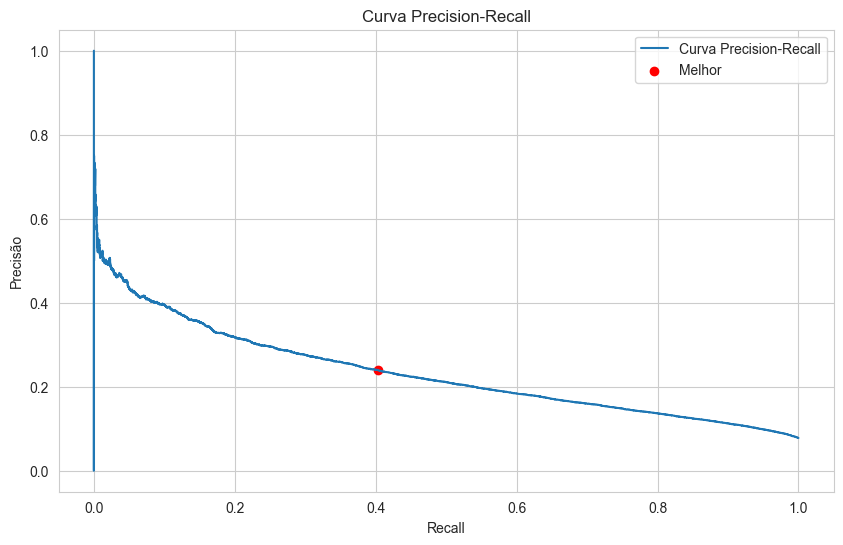

In [321]:
# Calculando as probabilidades de previsão
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculando precisão e recall para vários limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculand a pontuação F1 para cada limiar
f1_scores = 2*recall*precision / (recall + precision + 1e-8)

# Encontrando o índice do maior pontuação F1
ix = np.argmax(f1_scores)
print(f"Melhor Limiar={thresholds[ix]}, F1-Score={f1_scores[ix]}")

# Plotando a curva Precision-Recall
plt.figure(figsize=(10,6))
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.scatter(recall[ix], precision[ix], marker='o', color='red', label='Melhor')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

<div style="background-color: #FAE1BE">O gráfico mostra um ponto ótimo na curva Precision-Recall, que é um indicativo de que o modelo possui uma combinação equilibrada de precisão e recall. Isso significa que ele não só é bom em identificar corretamente as classes positivas, mas também em manter um número baixo de falsos positivos. Essa é uma ótima notícia, especialmente em situações onde é crítico não perder muitos casos positivos. É um sinal promissor da eficácia do modelo em capturar positivos verdadeiros enquanto mantém uma precisão respeitável.</div>

# Salvando o Modelo Treinado

## Arquivamento do Modelo com Pickle

Ao salvar um modelo treinado, garantimos que podemos reutilizar o mesmo estado do modelo posteriormente sem a necessidade de re-treinamento. Isso é útil para implantação em produção ou para continuar o trabalho em um momento posterior.

### Descrição

Este código realiza a tarefa de salvar o objeto do modelo treinado usando a biblioteca `pickle` do Python, que é um módulo padrão para serializar e deserializar objetos em Python. A serialização é o processo de transformar objetos em um fluxo de bytes para salvar em um arquivo ou banco de dados, ou transmitir pela rede. A deserialização é o processo inverso.

In [323]:
# Definir o nome do arquivo onde o modelo treinado será salvo
nome_arquivo = 'model_final.pkl'

# Utilizar o método `dump` do módulo pickle para salvar o modelo
# 'wb' indica que o arquivo está aberto para escrita em modo binário
pickle.dump(model, open(nome_arquivo, 'wb'))

# Uma vez executado, o modelo estará salvo no arquivo 'model_final.pkl'
# e pode ser carregado posteriormente usando pickle.load().

# Automação de Machine Learning com PyCaret
## Preparação de Dados e Treinamento do Modelo LightGBM
O PyCaret é uma biblioteca de automação de machine learning que simplifica o processo de codificação para a preparação de dados e o treinamento de modelos. Neste projeto, usaremos o PyCaret para processar uma base de dados de crédito e treinar um modelo LightGBM, além de gerar os gráficos e o pipeline de transformações.

### Carregamento dos Dados

In [325]:
# Carregamento dos dados
df = pd.read_feather('credit_scoring.ftr')

# Exibindo as primeiras linhas do DataFrame
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Inicialização do PyCaret

In [329]:
# Inicializando a configuração do PyCaret no ambiente
clf1 = setup(data=df, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 34)"
5,Transformed train set shape,"(525000, 34)"
6,Transformed test set shape,"(225000, 34)"
7,Ordinal features,3
8,Numeric features,6
9,Date features,1


### Comparação de Modelos

In [330]:
# Comparando todos os modelos disponíveis para encontrar o melhor
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9222,0.7801,0.0264,0.5460,0.0504,0.0435,0.1074,3.2880
ada,Ada Boost Classifier,0.9221,0.7800,0.0319,0.5378,0.0598,0.0515,0.1147,10.5280
gbc,Gradient Boosting Classifier,0.9221,0.7811,0.0249,0.5435,0.0476,0.0410,0.1038,39.8240
xgboost,Extreme Gradient Boosting,0.9220,0.7759,0.0301,0.5270,0.0569,0.0489,0.1119,3.1760
lr,Logistic Regression,0.9218,0.7746,0.0000,0.0000,0.0000,0.0000,0.0000,3.5420
ridge,Ridge Classifier,0.9218,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.5040
lda,Linear Discriminant Analysis,0.9218,0.6883,0.0000,0.0000,0.0000,0.0000,0.0000,2.7740
dummy,Dummy Classifier,0.9218,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.3170
knn,K Neighbors Classifier,0.9142,0.6406,0.0757,0.3046,0.1213,0.0931,0.1187,63.1370
et,Extra Trees Classifier,0.9000,0.5932,0.0883,0.1941,0.1213,0.0762,0.0829,28.2620


### Criação e Treinamento do Modelo LightGBM

In [332]:
# Criando o modelo LightGBM
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9220,0.7706,0.0248,0.5231,0.0474,0.0406,0.1012
1,0.9222,0.7879,0.0292,0.5479,0.0555,0.0480,0.1132
2,0.9223,0.7796,0.0270,0.5722,0.0516,0.0449,0.1121
3,0.9222,0.7817,0.0258,0.5550,0.0493,0.0427,0.1073
4,0.9219,0.7838,0.0236,0.5105,0.0452,0.0385,0.0971
5,0.9227,0.7768,0.0295,0.6142,0.0563,0.0494,0.1225
6,0.9226,0.7830,0.0287,0.6020,0.0549,0.0481,0.1194
7,0.9217,0.7790,0.0256,0.4861,0.0486,0.0411,0.0977
8,0.9220,0.7792,0.0263,0.5217,0.0501,0.0429,0.1039


### Afinação do Modelo

In [333]:
# Afinação do modelo para melhorar o desempenho
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.7718,0.0261,0.5815,0.0499,0.0435,0.1112
1,0.9222,0.7884,0.0295,0.5500,0.0560,0.0484,0.1140
2,0.9227,0.7803,0.0339,0.5966,0.0641,0.0562,0.1289
3,0.9222,0.7826,0.0285,0.5545,0.0542,0.0469,0.1127
4,0.9220,0.7847,0.0290,0.5219,0.0549,0.0471,0.1092
5,0.9228,0.7772,0.0336,0.6133,0.0637,0.0561,0.1308
6,0.9223,0.7836,0.0295,0.5628,0.0560,0.0486,0.1157
7,0.9218,0.7801,0.0275,0.5045,0.0522,0.0445,0.1039
8,0.9219,0.7799,0.0256,0.5147,0.0487,0.0416,0.1016


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Avaliação do Modelo

In [335]:
# Avaliando o modelo afiado
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Geração de Gráficos

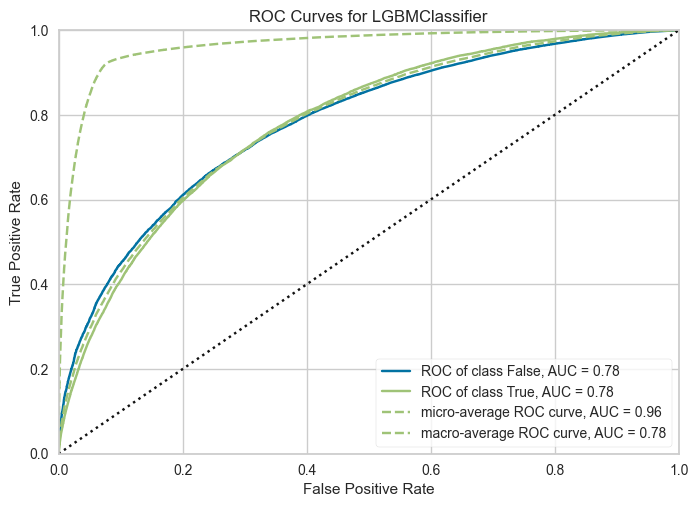

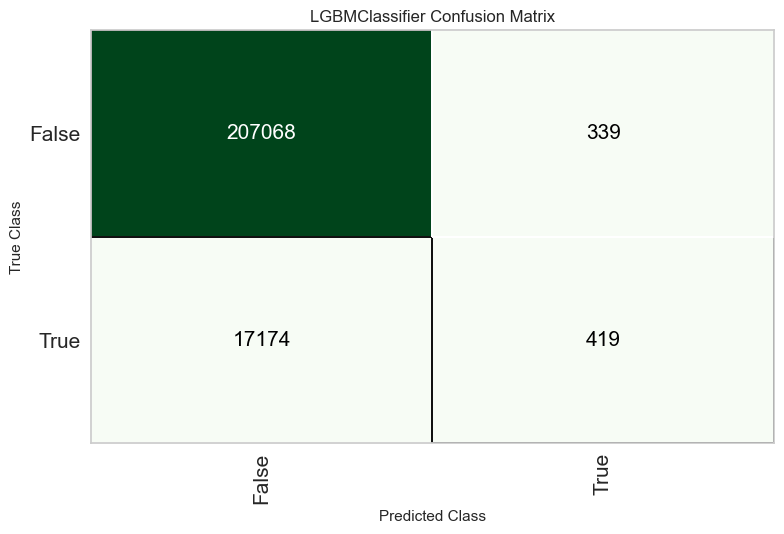

In [336]:
# Plotar gráficos importantes
plot_model(tuned_lgbm, plot='auc')
plot_model(tuned_lgbm, plot='confusion_matrix')

### Pipeline Final

In [337]:
# Finalizar o modelo para fazer previsões em dados não vistos
final_lgbm = finalize_model(tuned_lgbm)

### Salvamento do Modelo

In [339]:
# Salvando o modelo finalizado
save_model(final_lgbm, 'final_lgbm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_ra

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.